In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg16, VGG16_Weights

import copy

import utils.utils as utils

import os
import time

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

In [3]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resize F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)


In [4]:
def total_variation(img_batch):
    batch_size = img_batch.shape[0]
    return (torch.sum(torch.abs(img_batch[:, :, :, :-1] - img_batch[:, :, :, 1:])) +
            torch.sum(torch.abs(img_batch[:, :, :-1, :] - img_batch[:, :, 1:, :]))) / batch_size


In [5]:
class ImageTransformationNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Non-linearity
        self.relu = torch.nn.ReLU()

        # Down-sampling convolution layers
        numChannels = [3, 32, 64, 128]
        kernels = [9, 3, 3]
        strides = [1, 2, 2]

        self.conv1 = nn.Conv2d(numChannels[0], numChannels[1], kernel_size=kernels[0], stride=strides[0], padding=kernels[0]//2, padding_mode='reflect')
        self.in1 = nn.InstanceNorm2d(numChannels[1], affine=True)
        self.conv2 = nn.Conv2d(numChannels[1], numChannels[2], kernel_size=kernels[1], stride=strides[1], padding=kernels[1]//2, padding_mode='reflect')
        self.in2 = nn.InstanceNorm2d(numChannels[2], affine=True)
        self.conv3 = nn.Conv2d(numChannels[2], numChannels[3], kernel_size=kernels[2], stride=strides[2], padding=kernels[2]//2, padding_mode='reflect')
        self.in3 = nn.InstanceNorm2d(numChannels[3], affine=True)

        # Residual layers
        res_block_num_of_filters = 128
        self.res1 = ResidualBlock(res_block_num_of_filters)
        self.res2 = ResidualBlock(res_block_num_of_filters)
        self.res3 = ResidualBlock(res_block_num_of_filters)
        self.res4 = ResidualBlock(res_block_num_of_filters)
        self.res5 = ResidualBlock(res_block_num_of_filters)

        # Up-sampling convolution layers
        numChannels.reverse()
        kernels.reverse()
        strides.reverse()
        self.up1 = UpsampleConvLayer(numChannels[0], numChannels[1], kernel_size=kernels[0], stride=strides[0])
        self.in4 = nn.InstanceNorm2d(numChannels[1], affine=True)
        self.up2 = UpsampleConvLayer(numChannels[1], numChannels[2], kernel_size=kernels[1], stride=strides[1])
        self.in5 = nn.InstanceNorm2d(numChannels[2], affine=True)
        self.up3 = nn.Conv2d(numChannels[2], numChannels[3], kernel_size=kernels[2], stride=strides[2], padding=kernels[2]//2, padding_mode='reflect')

    def forward(self, x):
        x = self.relu(self.in1(self.conv1(x)))
        x = self.relu(self.in2(self.conv2(x)))
        x = self.relu(self.in3(self.conv3(x)))
        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        x = self.res4(x)
        x = self.res5(x)
        x = self.relu(self.in4(self.up1(x)))
        x = self.relu(self.in5(self.up2(x)))
        # No tanh activation here as originally proposed by J.Johnson, I didn't get any improvements by using it,
        # if you get better results using it feel free to make a PR
        return self.up3(x)



class ResidualBlock(torch.nn.Module):

    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        kernel_size = 3
        stride_size = 1
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=kernel_size, stride=stride_size, padding=kernel_size//2, padding_mode='reflect')
        self.in1 = nn.InstanceNorm2d(channels, affine=True)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=kernel_size, stride=stride_size, padding=kernel_size//2, padding_mode='reflect')
        self.in2 = nn.InstanceNorm2d(channels, affine=True)
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.relu(self.in1(self.conv1(x)))
        out = self.in2(self.conv2(out))
        return out + residual  


class UpsampleConvLayer(torch.nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super().__init__()
        self.upsampling_factor = stride
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=kernel_size//2, padding_mode='reflect')

    def forward(self, x):
        if self.upsampling_factor > 1:
            x = nn.functional.interpolate(x, scale_factor=self.upsampling_factor, mode='nearest')
        return self.conv(x)

In [6]:
class LossNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()

        cnn = vgg16(weights=VGG16_Weights.DEFAULT).features.eval()
        

        self.feature_maps = dict()
        self.feature_maps['relu1_2'] = nn.Sequential()
        self.feature_maps['relu2_2'] = nn.Sequential()
        self.feature_maps['relu3_3'] = nn.Sequential()
        self.feature_maps['relu4_3'] = nn.Sequential()

        names = ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3']
        
        i = 1
        j = 1

        for layer in cnn.children():

            if isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
                i += 1
                j = 1
            elif isinstance(layer, nn.Conv2d):
                name = 'conv{}_{}'.format(i,j)
            elif isinstance(layer, nn.ReLU):
                name = 'relu{}_{}'.format(i,j)
                j += 1

            if i == 5:
                break
            
            self.feature_maps[names[i-1]].add_module(name,layer)
        
        for param in self.parameters():
                param.requires_grad = False


    def forward(self,x):
            
        x = self.feature_maps['relu1_2'](x)
        feature_map1 = x
        x = self.feature_maps['relu2_2'](x)
        feature_map2 = x
        x = self.feature_maps['relu3_3'](x)
        feature_map3 = x
        x = self.feature_maps['relu4_3'](x)
        feature_map4 = x

        return feature_map1, feature_map2, feature_map3, feature_map4
            

In [9]:
def train(style_image_path,
          image_size,
          data_path,
          subset_size,
          batch_size,
          num_epochs,
          content_weight,
          style_weight,
          tv_weight,
          model_path,
          continue_train = False,
          subset_start = 0):
    

    #writer = SummaryWriter()  # (tensorboard) writer will output to ./runs/ directory by default
    #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



    # prepare neural networks
    transform_net = ImageTransformationNetwork().to(device)
    loss_net = LossNetwork().to(device)

    # continue_train is True means that we continue to train the network
    # in that case model_path is the model to be continued to train

    if continue_train == True:
        transform_net.load_state_dict(torch.load(model_path))
    
    transform_net.train()


    # prepare data loader
    train_loader = utils.get_training_data_loader(image_size, data_path, subset_size, batch_size, num_epochs, subset_start)

    

    optimizer = optim.Adam(transform_net.parameters())

    # Calculate style image's Gram matrices (style representation)
    # Built over feature maps as produced by the perceptual net - VGG16

    style_image = utils.prepare_img(style_image_path, target_shape = None, device=device, batch_size=batch_size)
    style_feature_maps = loss_net(style_image)
    
    style_feature_grams = []
    for feature_map in style_feature_maps:
        style_feature_grams.append(gram_matrix(feature_map))
    



    #style_img_path = os.path.join(training_config['style_images_path'], training_config['style_img_name'])
    #style_img = utils.prepare_img(style_img_path, target_shape=None, device=device, batch_size=training_config['batch_size'])
    #style_img_set_of_feature_maps = perceptual_loss_net(style_img)
    #target_style_representation = [utils.gram_matrix(x) for x in style_img_set_of_feature_maps]

    #utils.print_header(training_config)



    # Tracking loss metrics, NST is ill-posed we can only track loss and visual appearance of the stylized images
    #acc_content_loss, acc_style_loss, acc_tv_loss = [0., 0., 0.]
    ts = time.time()

    print("training...")

    for epoch in range(num_epochs):

        for batch_id, (batch, _) in enumerate(train_loader):

            
            
            

            # Feed content batch through transformer net
            content_batch = batch.to(device)
            style_batch = transform_net(batch)


            # Feed content and stylized batch through perceptual net (VGG16)
            content_batch_feature_maps = loss_net(content_batch)
            stylized_batch_feature_maps = loss_net(style_batch)

            # Calculate content representations and content loss
            content_target = content_batch_feature_maps[2]
            content = stylized_batch_feature_maps[2]
            content_loss = F.mse_loss(content_target, content, reduction='mean')

            # Calculate style representation and style loss
            style_loss = 0.0

            feature_grams = []
            for feature_map in stylized_batch_feature_maps:
                feature_grams.append(gram_matrix(feature_map))

            
            for k in range(4):
                style_loss += F.mse_loss(style_feature_grams[k], feature_grams[k], reduction='mean')
            
            

            # Calculate total variation loss - enforces image smoothness
            #tv_loss = total_variation(style_batch)

            # Combine losses and do a backprop
            total_loss = content_weight*content_loss + style_weight*style_loss #+ tv_weight*tv_loss
            total_loss.backward(retain_graph=True)
            optimizer.step()

            optimizer.zero_grad()  # clear gradients for the next round

            #
            # Logging and checkpoint creation
            #
            #acc_content_loss += content_loss.item()
            #acc_style_loss += style_loss.item()
            #acc_tv_loss += tv_loss.item()


            if batch_id % 10 == 0:

                print('batch {}'.format(batch_id))
                print('style loss: {}'.format(style_loss))
                print('content loss: {}'.format(content_loss))
                print('total loss: {}'.format(total_loss))

            if batch_id % 100 == 0 and batch_id > 0:
                torch.save(transform_net.state_dict(), model_path)

            """
            if training_config['enable_tensorboard']:
                # log scalars
                writer.add_scalar('Loss/content-loss', content_loss.item(), len(train_loader) * epoch + batch_id + 1)
                writer.add_scalar('Loss/style-loss', style_loss.item(), len(train_loader) * epoch + batch_id + 1)
                writer.add_scalar('Loss/tv-loss', tv_loss.item(), len(train_loader) * epoch + batch_id + 1)
                writer.add_scalars('Statistics/min-max-mean-median', {'min': torch.min(stylized_batch), 'max': torch.max(stylized_batch), 'mean': torch.mean(stylized_batch), 'median': torch.median(stylized_batch)}, len(train_loader) * epoch + batch_id + 1)
                # log stylized image
                if batch_id % training_config['image_log_freq'] == 0:
                    stylized = utils.post_process_image(stylized_batch[0].detach().to('cpu').numpy())
                    stylized = np.moveaxis(stylized, 2, 0)  # writer expects channel first image
                    writer.add_image('stylized_img', stylized, len(train_loader) * epoch + batch_id + 1)
            
            if training_config['console_log_freq'] is not None and batch_id % training_config['console_log_freq'] == 0:
                print(f'time elapsed={(time.time()-ts)/60:.2f}[min]|epoch={epoch + 1}|batch=[{batch_id + 1}/{len(train_loader)}]|c-loss={acc_content_loss / training_config["console_log_freq"]}|s-loss={acc_style_loss / training_config["console_log_freq"]}|tv-loss={acc_tv_loss / training_config["console_log_freq"]}|total loss={(acc_content_loss + acc_style_loss + acc_tv_loss) / training_config["console_log_freq"]}')
                acc_content_loss, acc_style_loss, acc_tv_loss = [0., 0., 0.]
            
            if training_config['checkpoint_freq'] is not None and (batch_id + 1) % training_config['checkpoint_freq'] == 0:
                training_state = utils.get_training_metadata(training_config)
                training_state["state_dict"] = transformer_net.state_dict()
                training_state["optimizer_state"] = optimizer.state_dict()
                ckpt_model_name = f"ckpt_style_{training_config['style_img_name'].split('.')[0]}_cw_{str(training_config['content_weight'])}_sw_{str(training_config['style_weight'])}_tw_{str(training_config['tv_weight'])}_epoch_{epoch}_batch_{batch_id}.pth"
                torch.save(training_state, os.path.join(training_config['checkpoints_path'], ckpt_model_name))
            """
    #
    # Save model with additional metadata - like which commit was used to train the model, style/content weights, etc.
    #
            
    """
    training_state = utils.get_training_metadata(training_config)
    training_state["state_dict"] = transformer_net.state_dict()
    training_state["optimizer_state"] = optimizer.state_dict()
    model_name = f"style_{training_config['style_img_name'].split('.')[0]}_datapoints_{training_state['num_of_datapoints']}_cw_{str(training_config['content_weight'])}_sw_{str(training_config['style_weight'])}_tw_{str(training_config['tv_weight'])}.pth"
    torch.save(training_state, os.path.join(training_config['model_binaries_path'], model_name))
    """

    torch.save(transform_net.state_dict(), model_path)



In [24]:
style_image_path = "./images/vg_starry_night.jpg"
image_size = 512 if torch.cuda.is_available() else 128  
data_path = "./training_data"
subset_size = 3000
batch_size = 4
num_epochs = 2
content_weight = 1e0
style_weight = 4e5
tv_weight = 0  
model_path = "./models/starry_night_NST"
continue_train = True
subset_start = 2000



train(style_image_path,
                        image_size,
                        data_path,
                        subset_size,
                        batch_size,
                        num_epochs,
                        content_weight,
                        style_weight,
                        tv_weight,
                        model_path,
                        continue_train,
                        subset_start)
    


Using 6000 datapoints (1500 batches) starting from image 2000 (MS COCO images) for transformer network training.
training...
batch 0
style loss: 1.7736534573487006e-05
content loss: 18.247026443481445
total loss: 25.34164047241211
batch 10
style loss: 7.227239257190377e-05
content loss: 22.118581771850586
total loss: 51.02753829956055
batch 20
style loss: 4.344809349277057e-05
content loss: 19.493520736694336
total loss: 36.87275695800781
batch 30
style loss: 2.8421385650290176e-05
content loss: 21.71607208251953
total loss: 33.084625244140625
batch 40
style loss: 2.30531095439801e-05
content loss: 21.029926300048828
total loss: 30.251171112060547
batch 50
style loss: 2.0648772988351993e-05
content loss: 18.359844207763672
total loss: 26.619354248046875
batch 60
style loss: 1.8330350940232165e-05
content loss: 18.27223777770996
total loss: 25.60437774658203
batch 70
style loss: 1.7901151295518503e-05
content loss: 19.582250595092773
total loss: 26.74271011352539
batch 80
style loss: 1.

In [25]:
def FastNST(image_path,image_width,model_path):
    
    style_net = ImageTransformationNetwork().to(device)
    style_net.load_state_dict(torch.load(model_path))
    style_net.eval()    


    with torch.no_grad():


        content_image = utils.prepare_img(image_path, image_width, device)
        stylized_image = style_net(content_image).to('cpu').numpy()[0]
        #utils.save_and_maybe_display_image(inference_config, stylized_img, should_display=inference_config['should_not_display'])
        stylized_image = utils.post_process_image(stylized_image)
        plt.imshow(stylized_image)
        plt.show()



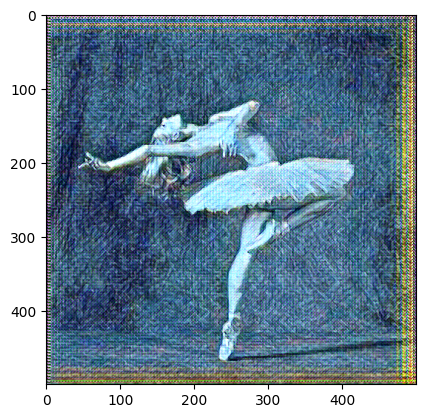

In [27]:
image_path = "./images/dancing.jpg"
image_width = 500
model_path = "./models/starry_night_NST"

FastNST(image_path,image_width,model_path)